In [1]:
import numpy as np 
import torch 
import math 
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import time

In [3]:
N_samples = 1000
p = 100
d = 40


In [4]:
X = torch.randn(N_samples, d)
true_beta = torch.randn(d,p)
true_alpha = torch.randn(d, p)
Y = X@true_beta + torch.randn(N_samples, p) 
Y_bis = X@true_alpha + torch.randn(N_samples,p) 

In [8]:
def get_batch(X,Y,batch_size): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 Y_bis[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  Y_bis[indices[-last_batch_size:]],indices[-last_batch_size:],
                )
        


In [44]:
def f(x,y_i): 
    return 1/2*torch.norm(x@beta-y_i)**2

def F(beta): 
    return 1/2*torch.mean(torch.norm(Y-X@beta, dim = (1))**2)

def F_bis(alpha): 
    return 1/2*torch.mean(torch.norm(Y_bis-X@alpha, dim = (1))**2)
def grad_f(beta,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)
def grad_f_bis(alpha,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)

def grad_F(beta): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y-X@beta).unsqueeze(1)) , axis = 0)
def grad_F_bis(alpha): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y_bis-X@alpha).unsqueeze(1)) , axis = 0)
    
def batch_grad(beta,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@beta).unsqueeze(1))
def batch_grad_bis(alpha,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@alpha).unsqueeze(1))


def fit(SAGA_bool, SVRG_bool, nb_step, choice_optim, lr, batch_size):
    beta = torch.zeros((d,p),requires_grad = True) + true_beta
    beta = torch.clone(true_beta) + torch.randn(d,p)
    beta.requires_grad_(True)
    alpha = torch.zeros((d,p), requires_grad = True) + true_alpha
    alpha = torch.clone(true_alpha) + torch.randn(d,p)
    alpha.requires_grad_(True)
    if SAGA_bool == False : 
        optim = choice_optim([alpha,beta], lr = lr)
    else : 
        init_grad_alpha = batch_grad(alpha, X, Y_bis)
        init_grad_beta = batch_grad(beta, X, Y)
        init_grads = [init_grad_alpha, init_grad_beta]
        optim = choice_optim([alpha,beta], init_grads, lr)
    MSE_alpha_list = []
    MSE_beta_list = []
    running_times = []
    t0 = time.time()
    for i in range(nb_step):
        if SVRG_bool:
            optim.update_mean_grad([grad_F_bis(alpha).detach(),grad_F(beta).detach()])
            alpha.old_param = torch.clone(alpha)
            beta.old_param = torch.clone(beta)
        for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, batch_size): 
            
            batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)
            alpha.grad = torch.mean(batch_grad_alpha, axis = 0)#+torch.randn(d,p)/1.5
            
            batch_grad_beta = batch_grad(beta, x_b, y_b)# + torch.randn(d,p)/1.5
            beta.grad = torch.mean(batch_grad_beta, axis = 0)
            
            if SVRG_bool : 
                alpha.old_grad = torch.mean(batch_grad(alpha.old_param, x_b,y_b_bis), axis = 0)
                beta.old_grad = torch.mean(batch_grad(beta.old_param, x_b, y_b), axis = 0)
                
            if SAGA_bool : 
                optim.step([batch_grad_alpha,batch_grad_beta], selected_indices)
            else : 
                optim.step()
            MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2).item())
            MSE_beta_list.append(torch.mean((beta-true_beta)**2).item())
            running_times.append(time.time()-t0)
            
        
    return MSE_alpha_list, MSE_beta_list, running_times

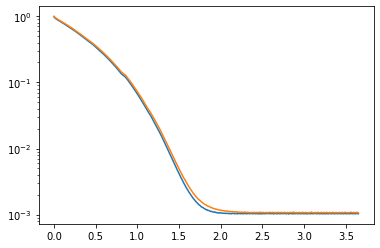

MSE_alpha 0.0010385200614109636
MSE_beta 0.0010745537059847266


In [45]:
MSE_alpha_torch, MSE_beta_torch, running_torch = fit(False,False, 100, torch.optim.RMSprop, 0.0008, 10)
show(MSE_alpha_torch, MSE_beta_torch, running_torch)
print('MSE_alpha', np.mean(MSE_alpha_torch[-20:]))
print('MSE_beta', np.mean(MSE_beta_torch[-20:]))

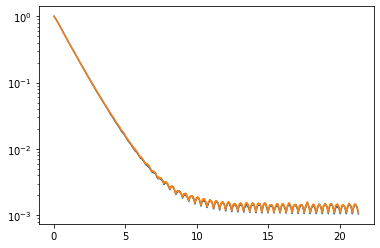

MSE_alpha 0.0013153616728959604
MSE_beta 0.0013400289666606114


In [46]:
MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA = fit(True,False,  50, SAGA, 0.002, 10)
show(MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA)
print('MSE_alpha', np.mean(MSE_alpha_SAGA[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAGA[-200:]))

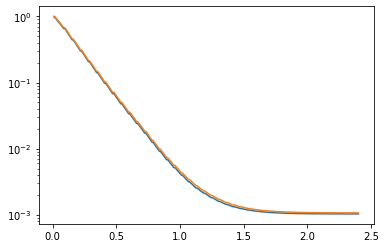

MSE_alpha 0.001029597775777802
MSE_beta 0.001068564427550882


In [47]:
MSE_alpha_SVRG, MSE_beta_SVRG, running_SVRG = fit(False,True,  40, SVRG, 0.002, 10)
show(MSE_alpha_SVRG, MSE_beta_SVRG, running_SVRG)
print('MSE_alpha', np.mean(MSE_alpha_SVRG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SVRG[-200:]))

dims : [torch.Size([4, 10]), torch.Size([4, 10])]


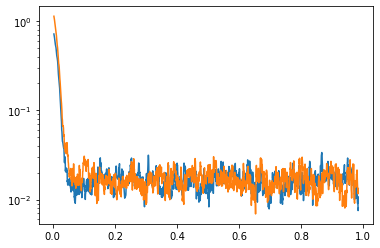

MSE_alpha 0.017236574389971792
MSE_beta 0.016783298472873867


In [296]:
MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA = fit(True,False, 100, SAGA, 0.05,15)
show(MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA)
print('MSE_alpha', np.mean(MSE_alpha_SAGA[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAGA[-200:]))

In [10]:
def show(MSE_alpha_list, MSE_beta_list, running_times): 
    plt.plot(running_times, MSE_alpha_list)
    plt.plot(running_times, MSE_beta_list)
    plt.yscale('log')
    plt.show()

In [26]:
class SVRG(Optimizer):
    def __init__(self, params, lr):
        '''
        initialization for the SAGA optimizer. 
        
        args : 
            params : list with each parameters
            lr : learning rate 
            init_grad_means : for each param in params. should be a list of length 
            nb_param. for each element in the list, the size should be 
            (shape of the parameter) 
            We will associate to each parameter an estimation of the gradient 
            of the objective function. Here, we will estimate this by evaluating 
            this at the starting point.  
        '''
            
        # set a warning message if all the sample size are differents. 
        defaults = dict(lr=lr)#, momentum=momentum, dampening=dampening,
                        #weight_decay=weight_decay, nesterov=nesterov)
        super(SVRG, self).__init__(params, defaults)
    @torch.no_grad()            
    def step(self):
        """Performs a single optimization step.
        Args:
            batch_grads : list that contains the gradients computed for a subset 
            of the samples. should be a list of size nb_params and each item
            should be of size (batch_size, shape of the parameter)
            
            selected_indices : list of indices, the ones we used to estimate the gradient with.
            
        """
        loss = None
        for group in self.param_groups:
            params_with_grad = []
            lr = group['lr']
            for param in group['params']:
                if param.grad is not None:
                    params_with_grad.append(param)
                    state = self.state[param]
            self.parameter_step(params_with_grad, lr)
        return loss
    def parameter_step(self,params_with_grad, lr): 
        for i, param in enumerate(params_with_grad): 
            param-= lr*(param.grad-param.old_grad + param.grad_mean)
            
    def update_mean_grad(self, grad_means):
        for group in self.param_groups:
            for i,param in enumerate(group['params']): 
                param.grad_mean = grad_means[i]

In [12]:
class SAGA(Optimizer):
    '''
    This class aims at defining the SAGA optimizer in pytorch, deriving from 
    the torch.optim class. We hope that we will be able to call torch.optim.SAGA 
    and the attributes (such as .step, .zero_grad) as we do for torch.optim.SGD
    '''
    def __init__(self, params, init_grads, lr):
        '''
        initialization for the SAGA optimizer. 
        
        args : 
            params : list with each parameters
            lr : learning rate 
            init_grad : for each param in params, for each sample. should be a list of length 
            nb_param. for each element in the list, the size should be 
            (N_samples, shape of the parameter)
            in the samples we have, we need a first gradient to store. 
            We will associate to each sample i the gradient of the corresponding function i  
            evaluated in the starting point. 
        '''
            
        # set a warning message if all the sample size are differents. 
        self.sample_size = init_grads[0].shape[0]
        defaults = dict(lr=lr, table = init_grads)#, momentum=momentum, dampening=dampening,
                        #weight_decay=weight_decay, nesterov=nesterov)
        super(SAGA, self).__init__(params, defaults)
        for group in self.param_groups: 
            for i,param in enumerate(group['params']): 
                param.table = init_grads[i]
                
        
    
    def __setstate__(self, state):
        super(SAGA, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            
    @torch.no_grad()
    def step(self, batch_grads, selected_indices):
        """Performs a single optimization step.
        Args:
            batch_grads : list that contains the gradients computed for a subset 
            of the samples. should be a list of size nb_params and each item
            should be of size (batch_size, shape of the parameter)
            
            selected_indices : list of indices, the ones we used to estimate the gradient with.
            
        """
        loss = None
        
        for group in self.param_groups:
            params_with_grad = []
            batch_tables = []
            means_batch_table = []
            lr = group['lr']
            for param in group['params']:
                if param.grad is not None:
                    params_with_grad.append(param)
                    batch_tables.append(param.table[selected_indices])
                    means_batch_table.append(torch.mean(param.table[selected_indices], axis = 0))
                    state = self.state[param]
            self.parameter_step(params_with_grad, means_batch_table, lr)
            saga_table_step(params_with_grad, batch_tables, selected_indices)

        return loss
    
    def parameter_step(self,params_with_grad,means_batch_table,lr):
        for i, param in enumerate(params_with_grad): 
            param-= lr*(param.grad-means_batch_table[i] + torch.mean(param.table, axis = 0))
            
            
def saga_table_step(params_with_grads, batch_tables, selected_indices):
    for i, param in enumerate(params_with_grads): 
        param.table[selected_indices] = batch_tables[i]
    

In [13]:
class SAG(SAGA): 
    '''
    This class aims at defining the SAGA optimizer in pytorch, deriving from 
    the torch.optim class. We hope that we will be able to call torch.optim.SAGA 
    and the attributes (such as .step, .zero_grad) as we do for torch.optim.SGD
    '''
    def __init__(self, params, init_grads, lr):
        '''
        initialization for the SAGA optimizer. 
        
        args : 
            params : list with each parameters
            lr : learning rate 
            init_grad : for each param in params, for each sample. should be a list of length 
            nb_param. for each element in the list, the size should be 
            (N_samples, shape of the parameter)
            in the samples we have, we need a first gradient to store. 
            We will associate to each sample i the gradient of the corresponding function i  
            evaluated in the starting point. 
        '''
        super(SAG,self).__init__(params,init_grads,lr)
        
    @torch.no_grad()
    def step(self, batch_grads, selected_indices):
        """Performs a single optimization step.
        Args:
            batch_grads : list that contains the gradients computed for a subset 
            of the samples. should be a list of size nb_params and each item
            should be of size (batch_size, shape of the parameter)
            
            selected_indices : list of indices, the ones we used to estimate the gradient with.
            
        """
        loss = None
        
        for group in self.param_groups:
            params_with_grad = []
            batch_tables = []
            means_batch_table = []
            lr = group['lr']
            for param in group['params']:
                if param.grad is not None:
                    params_with_grad.append(param)
                    batch_tables.append(param.table[selected_indices])
                    means_batch_table.append(torch.mean(param.table[selected_indices], axis = 0))
                    state = self.state[param]
            sag_parameter_step(params_with_grad, means_batch_table, lr)
            saga_table_step(params_with_grad, batch_tables, selected_indices)
        return loss
        
        
    def parameter_step(self,params_with_grad,means_batch_table,lr):
        sample_size = params_with_grad[0].table.shape[0]
        for i, param in enumerate(params_with_grad): 
            param-= lr*(1/sample_size*(param.grad-means_batch_table[i]) + torch.mean(param.table, axis = 0))



shape torch.Size([300, 4, 10])
dims : [torch.Size([4, 10]), torch.Size([4, 10])]
MSE :  tensor(0.0440, grad_fn=<MeanBackward0>)
MSE :  tensor(0.0694, grad_fn=<MeanBackward0>)


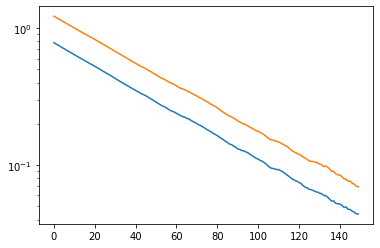

In [116]:
alpha = torch.zeros(d,p,requires_grad = True)
beta = torch.zeros(d,p ,requires_grad = True)
init_grad_alpha = batch_grad(alpha, X, Y_bis)
init_grad_beta = batch_grad(beta, X, Y)
init_grads = [init_grad_alpha, init_grad_beta]
saga = SAGA([alpha,beta],init_grads, 0.01)
MSE_alpha_list = []
MSE_beta_list = []
for i in range(5): 
    for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, 10): 
        batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)
        batch_grad_beta = batch_grad(beta, x_b, y_b)
        alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
        beta.grad = torch.mean(batch_grad_beta, axis = 0)
        saga.step([batch_grad_alpha,batch_grad_beta], selected_indices)
        MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2))
        MSE_beta_list.append(torch.mean((beta-true_beta)**2))
        
plt.plot(np.arange(0, len(MSE_alpha_list)), MSE_alpha_list)
plt.plot(np.arange(0, len(MSE_beta_list)), MSE_beta_list)
plt.yscale('log')
print('MSE : ', MSE_alpha_list[-1])
print('MSE : ', MSE_beta_list[-1])
#saga.step(1)

In [70]:
y = torch.zeros((15,4), requires_grad = True)
y_bis = torch.zeros((8,6), requires_grad = True)

In [71]:
true_alpha

tensor([[ 0.2914,  0.9492, -0.3462,  0.5065, -1.1999, -1.0172,  1.2064,  0.6506,
         -1.5739,  0.8133],
        [-0.4434,  1.1968,  0.2454, -0.5643,  0.9045, -0.3705,  1.6797,  1.3262,
          1.4530, -1.0903],
        [ 0.0062, -0.0218, -1.2418, -0.8894, -1.1913,  0.6112,  0.0321,  0.8183,
         -1.2064,  0.4688],
        [-0.4059, -0.3626,  0.5432,  1.2395, -0.5273,  0.8417,  0.5511, -1.4600,
          0.3286,  0.3510]])

In [73]:
first_init = torch.cat((2*(y-2).unsqueeze(0), 2*(y-1).unsqueeze(0), 2*(y-4).unsqueeze(0)),0)
second_init = torch.cat((2*(y_bis-2).unsqueeze(0), 2*(y_bis-1).unsqueeze(0), 2*(y_bis-4).unsqueeze(0)),0)
print(first_init.shape)
init_grads = [first_init, second_init]

torch.Size([3, 15, 4])
